In [1]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import scipy

import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns

get_ipython().run_line_magic('matplotlib', 'inline')

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, Normalizer, OneHotEncoder, LabelEncoder
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, PolynomialFeatures, FunctionTransformer

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import SplineTransformer
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

from scipy.stats import friedmanchisquare

from prophet import Prophet

from holidays import list_supported_countries
from prophet.make_holidays import make_holidays_df

from catboost import CatBoostRegressor
import category_encoders as ce

# Exploratory Data Analysis

In [3]:
df_test=pd.read_csv('test.csv')

In [4]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27375 entries, 0 to 27374
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       27375 non-null  int64 
 1   date     27375 non-null  object
 2   country  27375 non-null  object
 3   store    27375 non-null  object
 4   product  27375 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.0+ MB


In [5]:
display(df_test.head(3))
display(df_test.tail(3))
display(df_test.shape)
display(df_test.info())
display(df_test.nunique())
print('Number of duplicate rows (including first) in the table is:', df_test[df_test.duplicated(keep=False)].shape[0])

,id,date,country,store,product
0,136950,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding
1,136951,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs
2,136952,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People


,id,date,country,store,product
27372,164322,2022-12-31,Spain,Kagglazon,Using LLMs to Win Friends and Influence People
27373,164323,2022-12-31,Spain,Kagglazon,Using LLMs to Win More Kaggle Competitions
27374,164324,2022-12-31,Spain,Kagglazon,Using LLMs to Write Better


(27375, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27375 entries, 0 to 27374
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       27375 non-null  int64 
 1   date     27375 non-null  object
 2   country  27375 non-null  object
 3   store    27375 non-null  object
 4   product  27375 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.0+ MB


None

id         27375
date         365
country        5
store          3
product        5
dtype: int64

Number of duplicate rows (including first) in the table is: 0


In [6]:
df=pd.read_csv('train.csv')

In [7]:
display(df.head(3))
display(df.tail(3))
display(df.shape)
display(df.info())
display(df.nunique())
print('Number of duplicate rows (including first) in the table is:', df[df.duplicated(keep=False)].shape[0])

,id,date,country,store,product,num_sold
0,0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63
1,1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66
2,2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9


,id,date,country,store,product,num_sold
136947,136947,2021-12-31,Spain,Kagglazon,Using LLMs to Win Friends and Influence People,111
136948,136948,2021-12-31,Spain,Kagglazon,Using LLMs to Win More Kaggle Competitions,641
136949,136949,2021-12-31,Spain,Kagglazon,Using LLMs to Write Better,539


(136950, 6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136950 entries, 0 to 136949
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        136950 non-null  int64 
 1   date      136950 non-null  object
 2   country   136950 non-null  object
 3   store     136950 non-null  object
 4   product   136950 non-null  object
 5   num_sold  136950 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 6.3+ MB


None

id          136950
date          1826
country          5
store            3
product          5
num_sold      1028
dtype: int64

Number of duplicate rows (including first) in the table is: 0


In [8]:
df['date']=pd.to_datetime(df['date'])
df_test['date']=pd.to_datetime(df_test['date'])

In [9]:
df['country'] = df['country'].astype('category')
df['store'] = df['store'].astype('category')
df['product'] = df['product'].astype('category')

In [10]:
df_test['country'] = df_test['country'].astype('category')
df_test['store'] = df_test['store'].astype('category')
df_test['product'] = df_test['product'].astype('category')

In [11]:
# Descriptive stats for categorical features only.
category_columns = df.select_dtypes(['category']).columns
df[category_columns].describe().T

,count,unique,top,freq
country,136950,5,Argentina,27390
store,136950,3,Kagglazon,45650
product,136950,5,Using LLMs to Improve Your Coding,27390


In [12]:
def show_values(plot):
    for ax in plot.axes.ravel():
        # add annotations
        for c in ax.containers:
            # custom label calculates percent and add an empty string so 0 value bars don't have a number
            labels = [f'{w:0.0f}' if (w := v.get_height()) > 0 else '' for v in c]
            ax.bar_label(c, labels=labels, label_type='edge', fontsize=8, rotation=0, padding=2)
        ax.margins(y=0.2)

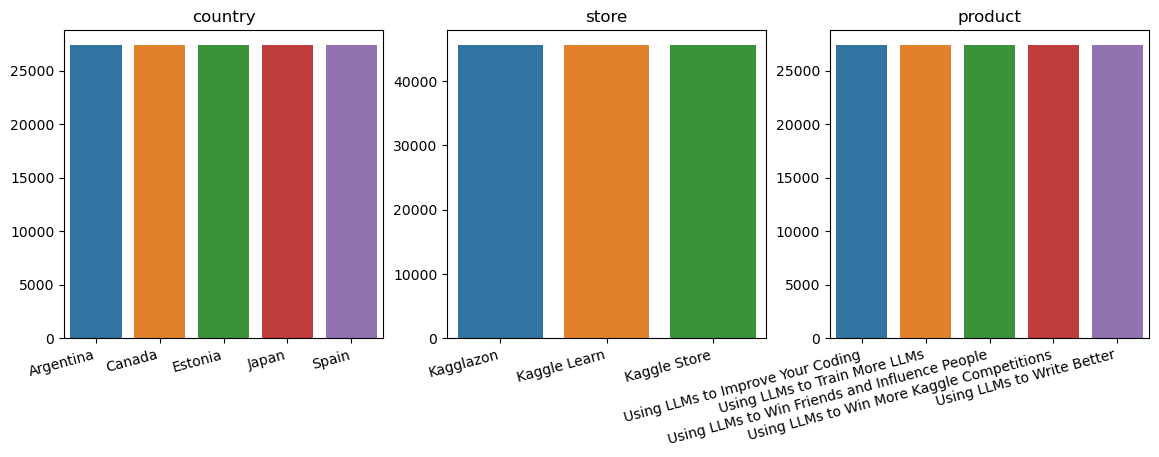

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14,4))
ax_num=0
for column in category_columns:
    sns.barplot(x=df[column].value_counts().index, y=df[column].value_counts(),
                ax=axes[ax_num]).set(title=column, ylabel=None)
    axes[ax_num].set_xticklabels(axes[ax_num].get_xticklabels(), 
                          rotation=15, 
                          horizontalalignment='right')
    ax_num+=1
plt.show()
plt.close()

In [14]:
"""fig, ax = plt.subplots(figsize=(14,5)) 
sns.lineplot(
    data=df,
    x="date", y="num_sold", hue="product")
plt.show()
plt.close()"""

'fig, ax = plt.subplots(figsize=(14,5)) \nsns.lineplot(\n    data=df,\n    x="date", y="num_sold", hue="product")\nplt.show()\nplt.close()'

In [15]:
"""fig, ax = plt.subplots(figsize=(14,5)) 
sns.lineplot(
    data=df,
    x="date", y="num_sold", hue="country")
plt.show()
plt.close()"""

'fig, ax = plt.subplots(figsize=(14,5)) \nsns.lineplot(\n    data=df,\n    x="date", y="num_sold", hue="country")\nplt.show()\nplt.close()'

In [16]:
"""fig, ax = plt.subplots(figsize=(14,5)) 
sns.lineplot(
    data=df,
    x="date", y="num_sold", hue="store")
plt.show()
plt.close()"""

'fig, ax = plt.subplots(figsize=(14,5)) \nsns.lineplot(\n    data=df,\n    x="date", y="num_sold", hue="store")\nplt.show()\nplt.close()'

* store and country display similar pattern across categories in time
* product display different pattern across categories in time

In [17]:
dfv00=df.copy()

### Feature Engineering Time Features

In [18]:
df['year']=df['date'].dt.year
df['month']=df['date'].dt.month
df['weekday']=df['date'].dt.dayofweek
df['quarter']=df['date'].dt.quarter
df['day']=df['date'].dt.day
df["week"]=df['date'].dt.weekofyear

In [19]:
df_test['year']=df_test['date'].dt.year
df_test['month']=df_test['date'].dt.month
df_test['weekday']=df_test['date'].dt.dayofweek
df_test['quarter']=df_test['date'].dt.quarter
df_test['day']=df_test['date'].dt.day
df_test["week"]=df_test['date'].dt.weekofyear

In [20]:
df['country'] = df['country'].astype('str')
df['store'] = df['store'].astype('str')
df['product'] = df['product'].astype('str')
df["country_store_product"]=df["country"]+"_"+df["store"]+"_"+df["product"]
df["country_store_product"]=df["country_store_product"].str.replace(' ', '')
df['country'] = df['country'].astype('category')
df['store'] = df['store'].astype('category')
df["country_store_product"]=df["country_store_product"].astype('category')

In [21]:
df.head(2)

,id,date,country,store,product,num_sold,year,month,weekday,quarter,day,week,country_store_product
0,0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63,2017,1,6,1,1,52,Argentina_KaggleLearn_UsingLLMstoImproveYourCo...
1,1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66,2017,1,6,1,1,52,Argentina_KaggleLearn_UsingLLMstoTrainMoreLLMs


In [22]:
df.country_store_product.nunique()

75

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136950 entries, 0 to 136949
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   id                     136950 non-null  int64         
 1   date                   136950 non-null  datetime64[ns]
 2   country                136950 non-null  category      
 3   store                  136950 non-null  category      
 4   product                136950 non-null  object        
 5   num_sold               136950 non-null  int64         
 6   year                   136950 non-null  int64         
 7   month                  136950 non-null  int64         
 8   weekday                136950 non-null  int64         
 9   quarter                136950 non-null  int64         
 10  day                    136950 non-null  int64         
 11  week                   136950 non-null  int64         
 12  country_store_product  136950 non-null  cate

In [24]:
# Descriptive stats for categorical features only.
time_columns = ['year','quarter','month','week','day','weekday',]

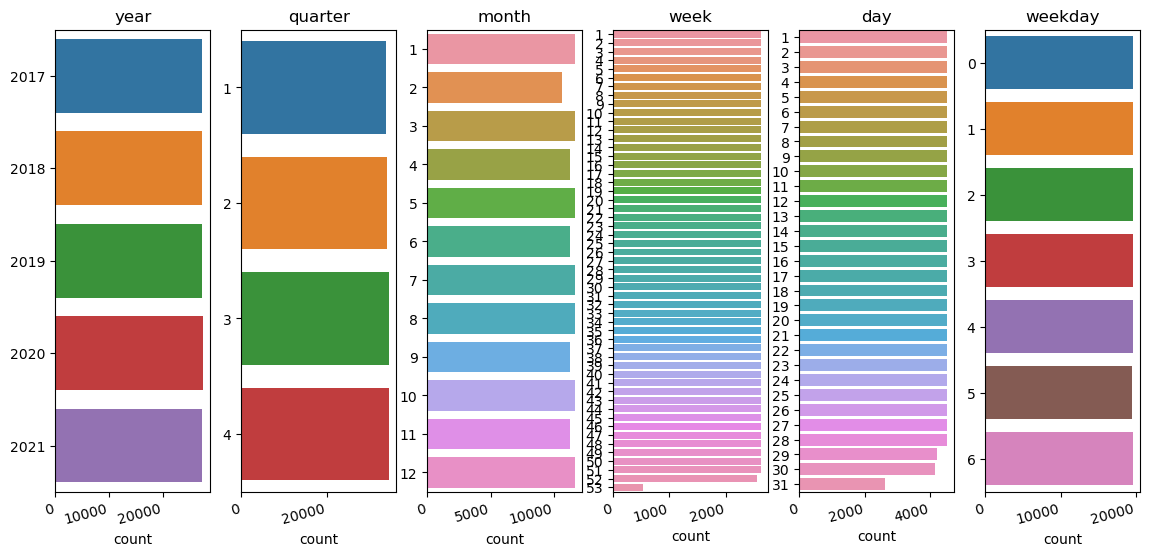

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(14,6))
ax_num=0
for column in time_columns:
    sns.countplot( data =df, y= column,
                ax=axes[ax_num]).set(title=column, ylabel=None)
    axes[ax_num].set_xticklabels(axes[ax_num].get_xticklabels(), 
                          rotation=15, 
                          horizontalalignment='right')
    ax_num+=1

In [26]:
"""fig, ax = plt.subplots(figsize=(14,5)) 
sns.lineplot(
    data=df,
    x="date", y="num_sold", hue="country_store")
plt.show()
plt.close()"""

'fig, ax = plt.subplots(figsize=(14,5)) \nsns.lineplot(\n    data=df,\n    x="date", y="num_sold", hue="country_store")\nplt.show()\nplt.close()'

In [27]:
plt.close('all')

## Analysing features

In [29]:
for i in time_columns:
    print("*"*66)
    print(i)
    df_trans=df[[i,'num_sold']].pivot(columns=i, values='num_sold')
    data=[]
    len_a=[]
    data_new=[]
    for col in df_trans.columns:
        a=df_trans[col].dropna().values.tolist()
        len_a.append(len(a))
        data.append(a)
    for alist in data:
        data_new.append(alist[:min(len_a)])
    print(f"friedmanchisquare {friedmanchisquare(*data_new)}")

******************************************************************
year
friedmanchisquare FriedmanchisquareResult(statistic=22924.538346239817, pvalue=0.0)
******************************************************************
quarter
friedmanchisquare FriedmanchisquareResult(statistic=5791.760326096964, pvalue=0.0)
******************************************************************
month
friedmanchisquare FriedmanchisquareResult(statistic=7827.859646305901, pvalue=0.0)
******************************************************************
week
friedmanchisquare FriedmanchisquareResult(statistic=5319.655923490411, pvalue=0.0)
******************************************************************
day
friedmanchisquare FriedmanchisquareResult(statistic=305.74549060253463, pvalue=1.9490617589509127e-47)
******************************************************************
weekday
friedmanchisquare FriedmanchisquareResult(statistic=65856.16748006426, pvalue=0.0)


In [30]:
df.columns

Index(['id', 'date', 'country', 'store', 'product', 'num_sold', 'year',
       'month', 'weekday', 'quarter', 'day', 'week', 'country_store_product'],
      dtype='object')

In [31]:
other_columns=['country', 'store', 'product','country_store_product']
for i in other_columns:
    print("*"*66)
    print(i)
    df_trans=df[[i,'num_sold']].pivot(columns=i, values='num_sold')
    data=[]
    len_a=[]
    data_new=[]
    for col in df_trans.columns:
        a=df_trans[col].dropna().values.tolist()
        len_a.append(len(a))
        data.append(a)
    for alist in data:
        data_new.append(alist[:min(len_a)])
    print(f"friedmanchisquare {friedmanchisquare(*data_new)}")

******************************************************************
country
friedmanchisquare FriedmanchisquareResult(statistic=106687.37919772958, pvalue=0.0)
******************************************************************
store
friedmanchisquare FriedmanchisquareResult(statistic=91300.0, pvalue=0.0)
******************************************************************
product
friedmanchisquare FriedmanchisquareResult(statistic=81426.44628936356, pvalue=0.0)
******************************************************************
country_store_product
friedmanchisquare FriedmanchisquareResult(statistic=132319.87456011944, pvalue=0.0)


# PROPHET MODEL

##  Splitting  dataset for evaluation

seperating a hold-out set to test the combined performance of final output of all models 

In [32]:
df.columns

Index(['id', 'date', 'country', 'store', 'product', 'num_sold', 'year',
       'month', 'weekday', 'quarter', 'day', 'week', 'country_store_product'],
      dtype='object')

In [33]:
features=['date','country_store_product','num_sold']
df_train=df[features]

In [34]:
def country_store_dfs_maker(df):
    country_store_dfs_dict={}
    for country_store in df["country_store_product"].unique():
        key=country_store
        value_df=df[df["country_store_product"]==country_store]
        value_df=value_df.drop(['country_store_product'],axis=1)
        value_df = value_df.rename(columns={'date': 'ds',
                        'num_sold': 'y'})
        country_store_dfs_dict[key]=value_df
    return country_store_dfs_dict

In [35]:
country_store_dfs_dict=country_store_dfs_maker(df_train)

In [36]:
country_store_dfs_dict.keys()

dict_keys(['Argentina_KaggleLearn_UsingLLMstoImproveYourCoding', 'Argentina_KaggleLearn_UsingLLMstoTrainMoreLLMs', 'Argentina_KaggleLearn_UsingLLMstoWinFriendsandInfluencePeople', 'Argentina_KaggleLearn_UsingLLMstoWinMoreKaggleCompetitions', 'Argentina_KaggleLearn_UsingLLMstoWriteBetter', 'Argentina_KaggleStore_UsingLLMstoImproveYourCoding', 'Argentina_KaggleStore_UsingLLMstoTrainMoreLLMs', 'Argentina_KaggleStore_UsingLLMstoWinFriendsandInfluencePeople', 'Argentina_KaggleStore_UsingLLMstoWinMoreKaggleCompetitions', 'Argentina_KaggleStore_UsingLLMstoWriteBetter', 'Argentina_Kagglazon_UsingLLMstoImproveYourCoding', 'Argentina_Kagglazon_UsingLLMstoTrainMoreLLMs', 'Argentina_Kagglazon_UsingLLMstoWinFriendsandInfluencePeople', 'Argentina_Kagglazon_UsingLLMstoWinMoreKaggleCompetitions', 'Argentina_Kagglazon_UsingLLMstoWriteBetter', 'Canada_KaggleLearn_UsingLLMstoImproveYourCoding', 'Canada_KaggleLearn_UsingLLMstoTrainMoreLLMs', 'Canada_KaggleLearn_UsingLLMstoWinFriendsandInfluencePeople', 'C

In [37]:
dataset_list=list(country_store_dfs_dict.values())

In [38]:
for i in dataset_list:
    display(i.head(2))
    print(i.shape)

,ds,y
0,2017-01-01,63
75,2017-01-02,51


(1826, 2)


,ds,y
1,2017-01-01,66
76,2017-01-02,47


(1826, 2)


,ds,y
2,2017-01-01,9
77,2017-01-02,7


(1826, 2)


,ds,y
3,2017-01-01,59
78,2017-01-02,43


(1826, 2)


,ds,y
4,2017-01-01,49
79,2017-01-02,35


(1826, 2)


,ds,y
5,2017-01-01,88
80,2017-01-02,74


(1826, 2)


,ds,y
6,2017-01-01,98
81,2017-01-02,77


(1826, 2)


,ds,y
7,2017-01-01,14
82,2017-01-02,11


(1826, 2)


,ds,y
8,2017-01-01,83
83,2017-01-02,70


(1826, 2)


,ds,y
9,2017-01-01,69
84,2017-01-02,55


(1826, 2)


,ds,y
10,2017-01-01,340
85,2017-01-02,250


(1826, 2)


,ds,y
11,2017-01-01,371
86,2017-01-02,273


(1826, 2)


,ds,y
12,2017-01-01,53
87,2017-01-02,52


(1826, 2)


,ds,y
13,2017-01-01,364
88,2017-01-02,236


(1826, 2)


,ds,y
14,2017-01-01,285
89,2017-01-02,206


(1826, 2)


,ds,y
15,2017-01-01,202
90,2017-01-02,156


(1826, 2)


,ds,y
16,2017-01-01,199
91,2017-01-02,150


(1826, 2)


,ds,y
17,2017-01-01,31
92,2017-01-02,26


(1826, 2)


,ds,y
18,2017-01-01,202
93,2017-01-02,158


(1826, 2)


,ds,y
19,2017-01-01,138
94,2017-01-02,123


(1826, 2)


,ds,y
20,2017-01-01,274
95,2017-01-02,253


(1826, 2)


,ds,y
21,2017-01-01,288
96,2017-01-02,240


(1826, 2)


,ds,y
22,2017-01-01,47
97,2017-01-02,46


(1826, 2)


,ds,y
23,2017-01-01,268
98,2017-01-02,252


(1826, 2)


,ds,y
24,2017-01-01,249
99,2017-01-02,205


(1826, 2)


,ds,y
25,2017-01-01,1041
100,2017-01-02,870


(1826, 2)


,ds,y
26,2017-01-01,1101
101,2017-01-02,930


(1826, 2)


,ds,y
27,2017-01-01,166
102,2017-01-02,141


(1826, 2)


,ds,y
28,2017-01-01,1062
103,2017-01-02,814


(1826, 2)


,ds,y
29,2017-01-01,866
104,2017-01-02,717


(1826, 2)


,ds,y
30,2017-01-01,92
105,2017-01-02,63


(1826, 2)


,ds,y
31,2017-01-01,89
106,2017-01-02,65


(1826, 2)


,ds,y
32,2017-01-01,14
107,2017-01-02,10


(1826, 2)


,ds,y
33,2017-01-01,81
108,2017-01-02,64


(1826, 2)


,ds,y
34,2017-01-01,70
109,2017-01-02,50


(1826, 2)


,ds,y
35,2017-01-01,132
110,2017-01-02,109


(1826, 2)


,ds,y
36,2017-01-01,129
111,2017-01-02,102


(1826, 2)


,ds,y
37,2017-01-01,19
112,2017-01-02,15


(1826, 2)


,ds,y
38,2017-01-01,137
113,2017-01-02,88


(1826, 2)


,ds,y
39,2017-01-01,106
114,2017-01-02,80


(1826, 2)


,ds,y
40,2017-01-01,501
115,2017-01-02,353


(1826, 2)


,ds,y
41,2017-01-01,481
116,2017-01-02,347


(1826, 2)


,ds,y
42,2017-01-01,70
117,2017-01-02,64


(1826, 2)


,ds,y
43,2017-01-01,468
118,2017-01-02,366


(1826, 2)


,ds,y
44,2017-01-01,383
119,2017-01-02,286


(1826, 2)


,ds,y
45,2017-01-01,167
120,2017-01-02,142


(1826, 2)


,ds,y
46,2017-01-01,162
121,2017-01-02,146


(1826, 2)


,ds,y
47,2017-01-01,26
122,2017-01-02,19


(1826, 2)


,ds,y
48,2017-01-01,163
123,2017-01-02,121


(1826, 2)


,ds,y
49,2017-01-01,119
124,2017-01-02,93


(1826, 2)


,ds,y
50,2017-01-01,270
125,2017-01-02,210


(1826, 2)


,ds,y
51,2017-01-01,246
126,2017-01-02,192


(1826, 2)


,ds,y
52,2017-01-01,39
127,2017-01-02,30


(1826, 2)


,ds,y
53,2017-01-01,266
128,2017-01-02,180


(1826, 2)


,ds,y
54,2017-01-01,191
129,2017-01-02,146


(1826, 2)


,ds,y
55,2017-01-01,938
130,2017-01-02,728


(1826, 2)


,ds,y
56,2017-01-01,869
131,2017-01-02,703


(1826, 2)


,ds,y
57,2017-01-01,147
132,2017-01-02,105


(1826, 2)


,ds,y
58,2017-01-01,970
133,2017-01-02,621


(1826, 2)


,ds,y
59,2017-01-01,701
134,2017-01-02,547


(1826, 2)


,ds,y
60,2017-01-01,122
135,2017-01-02,106


(1826, 2)


,ds,y
61,2017-01-01,125
136,2017-01-02,100


(1826, 2)


,ds,y
62,2017-01-01,20
137,2017-01-02,13


(1826, 2)


,ds,y
63,2017-01-01,106
138,2017-01-02,94


(1826, 2)


,ds,y
64,2017-01-01,90
139,2017-01-02,68


(1826, 2)


,ds,y
65,2017-01-01,177
140,2017-01-02,145


(1826, 2)


,ds,y
66,2017-01-01,198
141,2017-01-02,140


(1826, 2)


,ds,y
67,2017-01-01,29
142,2017-01-02,22


(1826, 2)


,ds,y
68,2017-01-01,184
143,2017-01-02,125


(1826, 2)


,ds,y
69,2017-01-01,139
144,2017-01-02,110


(1826, 2)


,ds,y
70,2017-01-01,724
145,2017-01-02,541


(1826, 2)


,ds,y
71,2017-01-01,681
146,2017-01-02,546


(1826, 2)


,ds,y
72,2017-01-01,107
147,2017-01-02,78


(1826, 2)


,ds,y
73,2017-01-01,673
148,2017-01-02,481


(1826, 2)


,ds,y
74,2017-01-01,520
149,2017-01-02,381


(1826, 2)


In [39]:
def train_valid_splitter(df_dict):
    train_dfs_dict={}
    valid_dfs_dict={}
    features=['date']
    for key, value in df_dict.items():
        
        train_dfs_dict[key]=value[value.ds < "2021-01-01"]
        valid_dfs_dict[key]=value[value.ds >= "2021-01-01"]
    return train_dfs_dict, valid_dfs_dict

In [40]:
train_dfs_dict, valid_dfs_dict = train_valid_splitter(country_store_dfs_dict)

In [41]:
for key, value in train_dfs_dict.items():
    print(key)
    display(value.head(2),value.shape)

Argentina_KaggleLearn_UsingLLMstoImproveYourCoding


,ds,y
0,2017-01-01,63
75,2017-01-02,51


(1461, 2)

Argentina_KaggleLearn_UsingLLMstoTrainMoreLLMs


,ds,y
1,2017-01-01,66
76,2017-01-02,47


(1461, 2)

Argentina_KaggleLearn_UsingLLMstoWinFriendsandInfluencePeople


,ds,y
2,2017-01-01,9
77,2017-01-02,7


(1461, 2)

Argentina_KaggleLearn_UsingLLMstoWinMoreKaggleCompetitions


,ds,y
3,2017-01-01,59
78,2017-01-02,43


(1461, 2)

Argentina_KaggleLearn_UsingLLMstoWriteBetter


,ds,y
4,2017-01-01,49
79,2017-01-02,35


(1461, 2)

Argentina_KaggleStore_UsingLLMstoImproveYourCoding


,ds,y
5,2017-01-01,88
80,2017-01-02,74


(1461, 2)

Argentina_KaggleStore_UsingLLMstoTrainMoreLLMs


,ds,y
6,2017-01-01,98
81,2017-01-02,77


(1461, 2)

Argentina_KaggleStore_UsingLLMstoWinFriendsandInfluencePeople


,ds,y
7,2017-01-01,14
82,2017-01-02,11


(1461, 2)

Argentina_KaggleStore_UsingLLMstoWinMoreKaggleCompetitions


,ds,y
8,2017-01-01,83
83,2017-01-02,70


(1461, 2)

Argentina_KaggleStore_UsingLLMstoWriteBetter


,ds,y
9,2017-01-01,69
84,2017-01-02,55


(1461, 2)

Argentina_Kagglazon_UsingLLMstoImproveYourCoding


,ds,y
10,2017-01-01,340
85,2017-01-02,250


(1461, 2)

Argentina_Kagglazon_UsingLLMstoTrainMoreLLMs


,ds,y
11,2017-01-01,371
86,2017-01-02,273


(1461, 2)

Argentina_Kagglazon_UsingLLMstoWinFriendsandInfluencePeople


,ds,y
12,2017-01-01,53
87,2017-01-02,52


(1461, 2)

Argentina_Kagglazon_UsingLLMstoWinMoreKaggleCompetitions


,ds,y
13,2017-01-01,364
88,2017-01-02,236


(1461, 2)

Argentina_Kagglazon_UsingLLMstoWriteBetter


,ds,y
14,2017-01-01,285
89,2017-01-02,206


(1461, 2)

Canada_KaggleLearn_UsingLLMstoImproveYourCoding


,ds,y
15,2017-01-01,202
90,2017-01-02,156


(1461, 2)

Canada_KaggleLearn_UsingLLMstoTrainMoreLLMs


,ds,y
16,2017-01-01,199
91,2017-01-02,150


(1461, 2)

Canada_KaggleLearn_UsingLLMstoWinFriendsandInfluencePeople


,ds,y
17,2017-01-01,31
92,2017-01-02,26


(1461, 2)

Canada_KaggleLearn_UsingLLMstoWinMoreKaggleCompetitions


,ds,y
18,2017-01-01,202
93,2017-01-02,158


(1461, 2)

Canada_KaggleLearn_UsingLLMstoWriteBetter


,ds,y
19,2017-01-01,138
94,2017-01-02,123


(1461, 2)

Canada_KaggleStore_UsingLLMstoImproveYourCoding


,ds,y
20,2017-01-01,274
95,2017-01-02,253


(1461, 2)

Canada_KaggleStore_UsingLLMstoTrainMoreLLMs


,ds,y
21,2017-01-01,288
96,2017-01-02,240


(1461, 2)

Canada_KaggleStore_UsingLLMstoWinFriendsandInfluencePeople


,ds,y
22,2017-01-01,47
97,2017-01-02,46


(1461, 2)

Canada_KaggleStore_UsingLLMstoWinMoreKaggleCompetitions


,ds,y
23,2017-01-01,268
98,2017-01-02,252


(1461, 2)

Canada_KaggleStore_UsingLLMstoWriteBetter


,ds,y
24,2017-01-01,249
99,2017-01-02,205


(1461, 2)

Canada_Kagglazon_UsingLLMstoImproveYourCoding


,ds,y
25,2017-01-01,1041
100,2017-01-02,870


(1461, 2)

Canada_Kagglazon_UsingLLMstoTrainMoreLLMs


,ds,y
26,2017-01-01,1101
101,2017-01-02,930


(1461, 2)

Canada_Kagglazon_UsingLLMstoWinFriendsandInfluencePeople


,ds,y
27,2017-01-01,166
102,2017-01-02,141


(1461, 2)

Canada_Kagglazon_UsingLLMstoWinMoreKaggleCompetitions


,ds,y
28,2017-01-01,1062
103,2017-01-02,814


(1461, 2)

Canada_Kagglazon_UsingLLMstoWriteBetter


,ds,y
29,2017-01-01,866
104,2017-01-02,717


(1461, 2)

Estonia_KaggleLearn_UsingLLMstoImproveYourCoding


,ds,y
30,2017-01-01,92
105,2017-01-02,63


(1461, 2)

Estonia_KaggleLearn_UsingLLMstoTrainMoreLLMs


,ds,y
31,2017-01-01,89
106,2017-01-02,65


(1461, 2)

Estonia_KaggleLearn_UsingLLMstoWinFriendsandInfluencePeople


,ds,y
32,2017-01-01,14
107,2017-01-02,10


(1461, 2)

Estonia_KaggleLearn_UsingLLMstoWinMoreKaggleCompetitions


,ds,y
33,2017-01-01,81
108,2017-01-02,64


(1461, 2)

Estonia_KaggleLearn_UsingLLMstoWriteBetter


,ds,y
34,2017-01-01,70
109,2017-01-02,50


(1461, 2)

Estonia_KaggleStore_UsingLLMstoImproveYourCoding


,ds,y
35,2017-01-01,132
110,2017-01-02,109


(1461, 2)

Estonia_KaggleStore_UsingLLMstoTrainMoreLLMs


,ds,y
36,2017-01-01,129
111,2017-01-02,102


(1461, 2)

Estonia_KaggleStore_UsingLLMstoWinFriendsandInfluencePeople


,ds,y
37,2017-01-01,19
112,2017-01-02,15


(1461, 2)

Estonia_KaggleStore_UsingLLMstoWinMoreKaggleCompetitions


,ds,y
38,2017-01-01,137
113,2017-01-02,88


(1461, 2)

Estonia_KaggleStore_UsingLLMstoWriteBetter


,ds,y
39,2017-01-01,106
114,2017-01-02,80


(1461, 2)

Estonia_Kagglazon_UsingLLMstoImproveYourCoding


,ds,y
40,2017-01-01,501
115,2017-01-02,353


(1461, 2)

Estonia_Kagglazon_UsingLLMstoTrainMoreLLMs


,ds,y
41,2017-01-01,481
116,2017-01-02,347


(1461, 2)

Estonia_Kagglazon_UsingLLMstoWinFriendsandInfluencePeople


,ds,y
42,2017-01-01,70
117,2017-01-02,64


(1461, 2)

Estonia_Kagglazon_UsingLLMstoWinMoreKaggleCompetitions


,ds,y
43,2017-01-01,468
118,2017-01-02,366


(1461, 2)

Estonia_Kagglazon_UsingLLMstoWriteBetter


,ds,y
44,2017-01-01,383
119,2017-01-02,286


(1461, 2)

Japan_KaggleLearn_UsingLLMstoImproveYourCoding


,ds,y
45,2017-01-01,167
120,2017-01-02,142


(1461, 2)

Japan_KaggleLearn_UsingLLMstoTrainMoreLLMs


,ds,y
46,2017-01-01,162
121,2017-01-02,146


(1461, 2)

Japan_KaggleLearn_UsingLLMstoWinFriendsandInfluencePeople


,ds,y
47,2017-01-01,26
122,2017-01-02,19


(1461, 2)

Japan_KaggleLearn_UsingLLMstoWinMoreKaggleCompetitions


,ds,y
48,2017-01-01,163
123,2017-01-02,121


(1461, 2)

Japan_KaggleLearn_UsingLLMstoWriteBetter


,ds,y
49,2017-01-01,119
124,2017-01-02,93


(1461, 2)

Japan_KaggleStore_UsingLLMstoImproveYourCoding


,ds,y
50,2017-01-01,270
125,2017-01-02,210


(1461, 2)

Japan_KaggleStore_UsingLLMstoTrainMoreLLMs


,ds,y
51,2017-01-01,246
126,2017-01-02,192


(1461, 2)

Japan_KaggleStore_UsingLLMstoWinFriendsandInfluencePeople


,ds,y
52,2017-01-01,39
127,2017-01-02,30


(1461, 2)

Japan_KaggleStore_UsingLLMstoWinMoreKaggleCompetitions


,ds,y
53,2017-01-01,266
128,2017-01-02,180


(1461, 2)

Japan_KaggleStore_UsingLLMstoWriteBetter


,ds,y
54,2017-01-01,191
129,2017-01-02,146


(1461, 2)

Japan_Kagglazon_UsingLLMstoImproveYourCoding


,ds,y
55,2017-01-01,938
130,2017-01-02,728


(1461, 2)

Japan_Kagglazon_UsingLLMstoTrainMoreLLMs


,ds,y
56,2017-01-01,869
131,2017-01-02,703


(1461, 2)

Japan_Kagglazon_UsingLLMstoWinFriendsandInfluencePeople


,ds,y
57,2017-01-01,147
132,2017-01-02,105


(1461, 2)

Japan_Kagglazon_UsingLLMstoWinMoreKaggleCompetitions


,ds,y
58,2017-01-01,970
133,2017-01-02,621


(1461, 2)

Japan_Kagglazon_UsingLLMstoWriteBetter


,ds,y
59,2017-01-01,701
134,2017-01-02,547


(1461, 2)

Spain_KaggleLearn_UsingLLMstoImproveYourCoding


,ds,y
60,2017-01-01,122
135,2017-01-02,106


(1461, 2)

Spain_KaggleLearn_UsingLLMstoTrainMoreLLMs


,ds,y
61,2017-01-01,125
136,2017-01-02,100


(1461, 2)

Spain_KaggleLearn_UsingLLMstoWinFriendsandInfluencePeople


,ds,y
62,2017-01-01,20
137,2017-01-02,13


(1461, 2)

Spain_KaggleLearn_UsingLLMstoWinMoreKaggleCompetitions


,ds,y
63,2017-01-01,106
138,2017-01-02,94


(1461, 2)

Spain_KaggleLearn_UsingLLMstoWriteBetter


,ds,y
64,2017-01-01,90
139,2017-01-02,68


(1461, 2)

Spain_KaggleStore_UsingLLMstoImproveYourCoding


,ds,y
65,2017-01-01,177
140,2017-01-02,145


(1461, 2)

Spain_KaggleStore_UsingLLMstoTrainMoreLLMs


,ds,y
66,2017-01-01,198
141,2017-01-02,140


(1461, 2)

Spain_KaggleStore_UsingLLMstoWinFriendsandInfluencePeople


,ds,y
67,2017-01-01,29
142,2017-01-02,22


(1461, 2)

Spain_KaggleStore_UsingLLMstoWinMoreKaggleCompetitions


,ds,y
68,2017-01-01,184
143,2017-01-02,125


(1461, 2)

Spain_KaggleStore_UsingLLMstoWriteBetter


,ds,y
69,2017-01-01,139
144,2017-01-02,110


(1461, 2)

Spain_Kagglazon_UsingLLMstoImproveYourCoding


,ds,y
70,2017-01-01,724
145,2017-01-02,541


(1461, 2)

Spain_Kagglazon_UsingLLMstoTrainMoreLLMs


,ds,y
71,2017-01-01,681
146,2017-01-02,546


(1461, 2)

Spain_Kagglazon_UsingLLMstoWinFriendsandInfluencePeople


,ds,y
72,2017-01-01,107
147,2017-01-02,78


(1461, 2)

Spain_Kagglazon_UsingLLMstoWinMoreKaggleCompetitions


,ds,y
73,2017-01-01,673
148,2017-01-02,481


(1461, 2)

Spain_Kagglazon_UsingLLMstoWriteBetter


,ds,y
74,2017-01-01,520
149,2017-01-02,381


(1461, 2)

In [42]:
for key, value in valid_dfs_dict.items():
    print(key)
    display(value.head(2),value.shape)

Argentina_KaggleLearn_UsingLLMstoImproveYourCoding


,ds,y
109575,2021-01-01,37
109650,2021-01-02,34


(365, 2)

Argentina_KaggleLearn_UsingLLMstoTrainMoreLLMs


,ds,y
109576,2021-01-01,37
109651,2021-01-02,34


(365, 2)

Argentina_KaggleLearn_UsingLLMstoWinFriendsandInfluencePeople


,ds,y
109577,2021-01-01,5
109652,2021-01-02,5


(365, 2)

Argentina_KaggleLearn_UsingLLMstoWinMoreKaggleCompetitions


,ds,y
109578,2021-01-01,38
109653,2021-01-02,34


(365, 2)

Argentina_KaggleLearn_UsingLLMstoWriteBetter


,ds,y
109579,2021-01-01,29
109654,2021-01-02,26


(365, 2)

Argentina_KaggleStore_UsingLLMstoImproveYourCoding


,ds,y
109580,2021-01-01,56
109655,2021-01-02,50


(365, 2)

Argentina_KaggleStore_UsingLLMstoTrainMoreLLMs


,ds,y
109581,2021-01-01,51
109656,2021-01-02,53


(365, 2)

Argentina_KaggleStore_UsingLLMstoWinFriendsandInfluencePeople


,ds,y
109582,2021-01-01,8
109657,2021-01-02,8


(365, 2)

Argentina_KaggleStore_UsingLLMstoWinMoreKaggleCompetitions


,ds,y
109583,2021-01-01,48
109658,2021-01-02,52


(365, 2)

Argentina_KaggleStore_UsingLLMstoWriteBetter


,ds,y
109584,2021-01-01,45
109659,2021-01-02,42


(365, 2)

Argentina_Kagglazon_UsingLLMstoImproveYourCoding


,ds,y
109585,2021-01-01,217
109660,2021-01-02,194


(365, 2)

Argentina_Kagglazon_UsingLLMstoTrainMoreLLMs


,ds,y
109586,2021-01-01,190
109661,2021-01-02,191


(365, 2)

Argentina_Kagglazon_UsingLLMstoWinFriendsandInfluencePeople


,ds,y
109587,2021-01-01,34
109662,2021-01-02,30


(365, 2)

Argentina_Kagglazon_UsingLLMstoWinMoreKaggleCompetitions


,ds,y
109588,2021-01-01,202
109663,2021-01-02,181


(365, 2)

Argentina_Kagglazon_UsingLLMstoWriteBetter


,ds,y
109589,2021-01-01,154
109664,2021-01-02,144


(365, 2)

Canada_KaggleLearn_UsingLLMstoImproveYourCoding


,ds,y
109590,2021-01-01,199
109665,2021-01-02,158


(365, 2)

Canada_KaggleLearn_UsingLLMstoTrainMoreLLMs


,ds,y
109591,2021-01-01,179
109666,2021-01-02,161


(365, 2)

Canada_KaggleLearn_UsingLLMstoWinFriendsandInfluencePeople


,ds,y
109592,2021-01-01,29
109667,2021-01-02,27


(365, 2)

Canada_KaggleLearn_UsingLLMstoWinMoreKaggleCompetitions


,ds,y
109593,2021-01-01,162
109668,2021-01-02,165


(365, 2)

Canada_KaggleLearn_UsingLLMstoWriteBetter


,ds,y
109594,2021-01-01,146
109669,2021-01-02,137


(365, 2)

Canada_KaggleStore_UsingLLMstoImproveYourCoding


,ds,y
109595,2021-01-01,279
109670,2021-01-02,250


(365, 2)

Canada_KaggleStore_UsingLLMstoTrainMoreLLMs


,ds,y
109596,2021-01-01,287
109671,2021-01-02,279


(365, 2)

Canada_KaggleStore_UsingLLMstoWinFriendsandInfluencePeople


,ds,y
109597,2021-01-01,45
109672,2021-01-02,39


(365, 2)

Canada_KaggleStore_UsingLLMstoWinMoreKaggleCompetitions


,ds,y
109598,2021-01-01,268
109673,2021-01-02,246


(365, 2)

Canada_KaggleStore_UsingLLMstoWriteBetter


,ds,y
109599,2021-01-01,207
109674,2021-01-02,194


(365, 2)

Canada_Kagglazon_UsingLLMstoImproveYourCoding


,ds,y
109600,2021-01-01,1041
109675,2021-01-02,927


(365, 2)

Canada_Kagglazon_UsingLLMstoTrainMoreLLMs


,ds,y
109601,2021-01-01,1064
109676,2021-01-02,1009


(365, 2)

Canada_Kagglazon_UsingLLMstoWinFriendsandInfluencePeople


,ds,y
109602,2021-01-01,149
109677,2021-01-02,144


(365, 2)

Canada_Kagglazon_UsingLLMstoWinMoreKaggleCompetitions


,ds,y
109603,2021-01-01,1042
109678,2021-01-02,875


(365, 2)

Canada_Kagglazon_UsingLLMstoWriteBetter


,ds,y
109604,2021-01-01,772
109679,2021-01-02,750


(365, 2)

Estonia_KaggleLearn_UsingLLMstoImproveYourCoding


,ds,y
109605,2021-01-01,96
109680,2021-01-02,92


(365, 2)

Estonia_KaggleLearn_UsingLLMstoTrainMoreLLMs


,ds,y
109606,2021-01-01,105
109681,2021-01-02,95


(365, 2)

Estonia_KaggleLearn_UsingLLMstoWinFriendsandInfluencePeople


,ds,y
109607,2021-01-01,15
109682,2021-01-02,15


(365, 2)

Estonia_KaggleLearn_UsingLLMstoWinMoreKaggleCompetitions


,ds,y
109608,2021-01-01,98
109683,2021-01-02,86


(365, 2)

Estonia_KaggleLearn_UsingLLMstoWriteBetter


,ds,y
109609,2021-01-01,84
109684,2021-01-02,72


(365, 2)

Estonia_KaggleStore_UsingLLMstoImproveYourCoding


,ds,y
109610,2021-01-01,171
109685,2021-01-02,147


(365, 2)

Estonia_KaggleStore_UsingLLMstoTrainMoreLLMs


,ds,y
109611,2021-01-01,156
109686,2021-01-02,138


(365, 2)

Estonia_KaggleStore_UsingLLMstoWinFriendsandInfluencePeople


,ds,y
109612,2021-01-01,24
109687,2021-01-02,23


(365, 2)

Estonia_KaggleStore_UsingLLMstoWinMoreKaggleCompetitions


,ds,y
109613,2021-01-01,145
109688,2021-01-02,131


(365, 2)

Estonia_KaggleStore_UsingLLMstoWriteBetter


,ds,y
109614,2021-01-01,114
109689,2021-01-02,116


(365, 2)

Estonia_Kagglazon_UsingLLMstoImproveYourCoding


,ds,y
109615,2021-01-01,591
109690,2021-01-02,499


(365, 2)

Estonia_Kagglazon_UsingLLMstoTrainMoreLLMs


,ds,y
109616,2021-01-01,592
109691,2021-01-02,504


(365, 2)

Estonia_Kagglazon_UsingLLMstoWinFriendsandInfluencePeople


,ds,y
109617,2021-01-01,92
109692,2021-01-02,81


(365, 2)

Estonia_Kagglazon_UsingLLMstoWinMoreKaggleCompetitions


,ds,y
109618,2021-01-01,548
109693,2021-01-02,461


(365, 2)

Estonia_Kagglazon_UsingLLMstoWriteBetter


,ds,y
109619,2021-01-01,497
109694,2021-01-02,396


(365, 2)

Japan_KaggleLearn_UsingLLMstoImproveYourCoding


,ds,y
109620,2021-01-01,108
109695,2021-01-02,119


(365, 2)

Japan_KaggleLearn_UsingLLMstoTrainMoreLLMs


,ds,y
109621,2021-01-01,107
109696,2021-01-02,117


(365, 2)

Japan_KaggleLearn_UsingLLMstoWinFriendsandInfluencePeople


,ds,y
109622,2021-01-01,17
109697,2021-01-02,18


(365, 2)

Japan_KaggleLearn_UsingLLMstoWinMoreKaggleCompetitions


,ds,y
109623,2021-01-01,108
109698,2021-01-02,110


(365, 2)

Japan_KaggleLearn_UsingLLMstoWriteBetter


,ds,y
109624,2021-01-01,88
109699,2021-01-02,94


(365, 2)

Japan_KaggleStore_UsingLLMstoImproveYourCoding


,ds,y
109625,2021-01-01,178
109700,2021-01-02,169


(365, 2)

Japan_KaggleStore_UsingLLMstoTrainMoreLLMs


,ds,y
109626,2021-01-01,166
109701,2021-01-02,168


(365, 2)

Japan_KaggleStore_UsingLLMstoWinFriendsandInfluencePeople


,ds,y
109627,2021-01-01,25
109702,2021-01-02,26


(365, 2)

Japan_KaggleStore_UsingLLMstoWinMoreKaggleCompetitions


,ds,y
109628,2021-01-01,150
109703,2021-01-02,166


(365, 2)

Japan_KaggleStore_UsingLLMstoWriteBetter


,ds,y
109629,2021-01-01,115
109704,2021-01-02,130


(365, 2)

Japan_Kagglazon_UsingLLMstoImproveYourCoding


,ds,y
109630,2021-01-01,639
109705,2021-01-02,709


(365, 2)

Japan_Kagglazon_UsingLLMstoTrainMoreLLMs


,ds,y
109631,2021-01-01,608
109706,2021-01-02,604


(365, 2)

Japan_Kagglazon_UsingLLMstoWinFriendsandInfluencePeople


,ds,y
109632,2021-01-01,98
109707,2021-01-02,97


(365, 2)

Japan_Kagglazon_UsingLLMstoWinMoreKaggleCompetitions


,ds,y
109633,2021-01-01,583
109708,2021-01-02,573


(365, 2)

Japan_Kagglazon_UsingLLMstoWriteBetter


,ds,y
109634,2021-01-01,486
109709,2021-01-02,490


(365, 2)

Spain_KaggleLearn_UsingLLMstoImproveYourCoding


,ds,y
109635,2021-01-01,100
109710,2021-01-02,88


(365, 2)

Spain_KaggleLearn_UsingLLMstoTrainMoreLLMs


,ds,y
109636,2021-01-01,98
109711,2021-01-02,99


(365, 2)

Spain_KaggleLearn_UsingLLMstoWinFriendsandInfluencePeople


,ds,y
109637,2021-01-01,17
109712,2021-01-02,14


(365, 2)

Spain_KaggleLearn_UsingLLMstoWinMoreKaggleCompetitions


,ds,y
109638,2021-01-01,97
109713,2021-01-02,79


(365, 2)

Spain_KaggleLearn_UsingLLMstoWriteBetter


,ds,y
109639,2021-01-01,78
109714,2021-01-02,73


(365, 2)

Spain_KaggleStore_UsingLLMstoImproveYourCoding


,ds,y
109640,2021-01-01,163
109715,2021-01-02,152


(365, 2)

Spain_KaggleStore_UsingLLMstoTrainMoreLLMs


,ds,y
109641,2021-01-01,156
109716,2021-01-02,156


(365, 2)

Spain_KaggleStore_UsingLLMstoWinFriendsandInfluencePeople


,ds,y
109642,2021-01-01,25
109717,2021-01-02,22


(365, 2)

Spain_KaggleStore_UsingLLMstoWinMoreKaggleCompetitions


,ds,y
109643,2021-01-01,157
109718,2021-01-02,144


(365, 2)

Spain_KaggleStore_UsingLLMstoWriteBetter


,ds,y
109644,2021-01-01,126
109719,2021-01-02,123


(365, 2)

Spain_Kagglazon_UsingLLMstoImproveYourCoding


,ds,y
109645,2021-01-01,600
109720,2021-01-02,567


(365, 2)

Spain_Kagglazon_UsingLLMstoTrainMoreLLMs


,ds,y
109646,2021-01-01,587
109721,2021-01-02,516


(365, 2)

Spain_Kagglazon_UsingLLMstoWinFriendsandInfluencePeople


,ds,y
109647,2021-01-01,92
109722,2021-01-02,86


(365, 2)

Spain_Kagglazon_UsingLLMstoWinMoreKaggleCompetitions


,ds,y
109648,2021-01-01,557
109723,2021-01-02,523


(365, 2)

Spain_Kagglazon_UsingLLMstoWriteBetter


,ds,y
109649,2021-01-01,481
109724,2021-01-02,432


(365, 2)

### Defining common functions

In [43]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [44]:
#This function to compute metrics
def calcMetrics(testActualVal, predictions):
    #regression evaluation measures
    data={"MAE":[metrics.mean_absolute_error(testActualVal, predictions)],
         "RMSE":[metrics.mean_squared_error(testActualVal, predictions)**0.5],
         "R2":[metrics.r2_score(testActualVal, predictions)],
         "SMAPE":[smape(testActualVal.to_numpy().flatten(), predictions)]}
    metric_df=pd.DataFrame(data)
    return metric_df

# Model - Prophet

In [47]:
list_supported_countries().keys()

dict_keys(['AL', 'DZ', 'AS', 'AD', 'AO', 'AR', 'AM', 'AW', 'AU', 'AT', 'AZ', 'BH', 'BD', 'BY', 'BE', 'BZ', 'BO', 'BA', 'BW', 'BR', 'BN', 'BG', 'BF', 'BI', 'KH', 'CM', 'CA', 'TD', 'CL', 'CN', 'CO', 'CR', 'HR', 'CU', 'CW', 'CY', 'CZ', 'DK', 'DJ', 'DO', 'EC', 'EG', 'SV', 'EE', 'SZ', 'ET', 'FI', 'FR', 'GA', 'GE', 'DE', 'GR', 'GU', 'GT', 'HN', 'HK', 'HU', 'IS', 'IN', 'ID', 'IE', 'IM', 'IL', 'IT', 'JM', 'JP', 'KZ', 'KE', 'KG', 'LV', 'LS', 'LI', 'LT', 'LU', 'MG', 'MW', 'MY', 'MT', 'MH', 'MX', 'MD', 'MC', 'ME', 'MA', 'MZ', 'NA', 'NL', 'NZ', 'NI', 'NG', 'MK', 'MP', 'NO', 'PK', 'PA', 'PY', 'PE', 'PH', 'PL', 'PT', 'PR', 'RO', 'RU', 'SM', 'SA', 'RS', 'SG', 'SK', 'SI', 'ZA', 'KR', 'ES', 'SE', 'CH', 'TW', 'TH', 'TN', 'TR', 'UA', 'AE', 'GB', 'UK', 'UM', 'VI', 'US', 'UY', 'UZ', 'VA', 'VE', 'VN', 'ZM', 'ZW'])

In [48]:
df.country.unique()

['Argentina', 'Canada', 'Estonia', 'Japan', 'Spain']
Categories (5, object): ['Argentina', 'Canada', 'Estonia', 'Japan', 'Spain']

In [49]:
trained_models_dict={}

In [50]:
for key, value in train_dfs_dict.items():
    print(key)
    
    model = Prophet()
    if 'Argentina' in key:
        model.add_country_holidays(country_name='AR')
    elif 'Canada' in key:
        model.add_country_holidays(country_name='CA')
    elif 'Estonia' in key:
        model.add_country_holidays(country_name='EE')
    elif 'Japan' in key:
        model.add_country_holidays(country_name='JP')
    else:
        model.add_country_holidays(country_name='ES')
        
    model_fit=model.fit(value)
    trained_models_dict[key]=model_fit

Argentina_KaggleLearn_UsingLLMstoImproveYourCoding


21:38:11 - cmdstanpy - INFO - Chain [1] start processing
21:38:11 - cmdstanpy - INFO - Chain [1] done processing
21:38:11 - cmdstanpy - INFO - Chain [1] start processing


Argentina_KaggleLearn_UsingLLMstoTrainMoreLLMs


21:38:11 - cmdstanpy - INFO - Chain [1] done processing
21:38:11 - cmdstanpy - INFO - Chain [1] start processing


Argentina_KaggleLearn_UsingLLMstoWinFriendsandInfluencePeople


21:38:11 - cmdstanpy - INFO - Chain [1] done processing
21:38:12 - cmdstanpy - INFO - Chain [1] start processing


Argentina_KaggleLearn_UsingLLMstoWinMoreKaggleCompetitions


21:38:12 - cmdstanpy - INFO - Chain [1] done processing
21:38:12 - cmdstanpy - INFO - Chain [1] start processing


Argentina_KaggleLearn_UsingLLMstoWriteBetter


21:38:12 - cmdstanpy - INFO - Chain [1] done processing
21:38:12 - cmdstanpy - INFO - Chain [1] start processing


Argentina_KaggleStore_UsingLLMstoImproveYourCoding


21:38:12 - cmdstanpy - INFO - Chain [1] done processing
21:38:12 - cmdstanpy - INFO - Chain [1] start processing


Argentina_KaggleStore_UsingLLMstoTrainMoreLLMs


21:38:12 - cmdstanpy - INFO - Chain [1] done processing
21:38:13 - cmdstanpy - INFO - Chain [1] start processing


Argentina_KaggleStore_UsingLLMstoWinFriendsandInfluencePeople


21:38:13 - cmdstanpy - INFO - Chain [1] done processing
21:38:13 - cmdstanpy - INFO - Chain [1] start processing


Argentina_KaggleStore_UsingLLMstoWinMoreKaggleCompetitions


21:38:13 - cmdstanpy - INFO - Chain [1] done processing
21:38:13 - cmdstanpy - INFO - Chain [1] start processing


Argentina_KaggleStore_UsingLLMstoWriteBetter


21:38:13 - cmdstanpy - INFO - Chain [1] done processing
21:38:13 - cmdstanpy - INFO - Chain [1] start processing


Argentina_Kagglazon_UsingLLMstoImproveYourCoding


21:38:13 - cmdstanpy - INFO - Chain [1] done processing
21:38:13 - cmdstanpy - INFO - Chain [1] start processing


Argentina_Kagglazon_UsingLLMstoTrainMoreLLMs


21:38:14 - cmdstanpy - INFO - Chain [1] done processing
21:38:14 - cmdstanpy - INFO - Chain [1] start processing


Argentina_Kagglazon_UsingLLMstoWinFriendsandInfluencePeople


21:38:14 - cmdstanpy - INFO - Chain [1] done processing
21:38:14 - cmdstanpy - INFO - Chain [1] start processing
21:38:14 - cmdstanpy - INFO - Chain [1] done processing


Argentina_Kagglazon_UsingLLMstoWinMoreKaggleCompetitions
Argentina_Kagglazon_UsingLLMstoWriteBetter


21:38:14 - cmdstanpy - INFO - Chain [1] start processing
21:38:14 - cmdstanpy - INFO - Chain [1] done processing
21:38:14 - cmdstanpy - INFO - Chain [1] start processing


Canada_KaggleLearn_UsingLLMstoImproveYourCoding


21:38:15 - cmdstanpy - INFO - Chain [1] done processing
21:38:15 - cmdstanpy - INFO - Chain [1] start processing


Canada_KaggleLearn_UsingLLMstoTrainMoreLLMs


21:38:15 - cmdstanpy - INFO - Chain [1] done processing
21:38:15 - cmdstanpy - INFO - Chain [1] start processing
21:38:15 - cmdstanpy - INFO - Chain [1] done processing


Canada_KaggleLearn_UsingLLMstoWinFriendsandInfluencePeople
Canada_KaggleLearn_UsingLLMstoWinMoreKaggleCompetitions


21:38:15 - cmdstanpy - INFO - Chain [1] start processing
21:38:15 - cmdstanpy - INFO - Chain [1] done processing
21:38:15 - cmdstanpy - INFO - Chain [1] start processing


Canada_KaggleLearn_UsingLLMstoWriteBetter


21:38:16 - cmdstanpy - INFO - Chain [1] done processing
21:38:16 - cmdstanpy - INFO - Chain [1] start processing


Canada_KaggleStore_UsingLLMstoImproveYourCoding


21:38:16 - cmdstanpy - INFO - Chain [1] done processing
21:38:16 - cmdstanpy - INFO - Chain [1] start processing


Canada_KaggleStore_UsingLLMstoTrainMoreLLMs


21:38:16 - cmdstanpy - INFO - Chain [1] done processing
21:38:16 - cmdstanpy - INFO - Chain [1] start processing


Canada_KaggleStore_UsingLLMstoWinFriendsandInfluencePeople


21:38:16 - cmdstanpy - INFO - Chain [1] done processing
21:38:16 - cmdstanpy - INFO - Chain [1] start processing


Canada_KaggleStore_UsingLLMstoWinMoreKaggleCompetitions


21:38:17 - cmdstanpy - INFO - Chain [1] done processing
21:38:17 - cmdstanpy - INFO - Chain [1] start processing


Canada_KaggleStore_UsingLLMstoWriteBetter


21:38:17 - cmdstanpy - INFO - Chain [1] done processing
21:38:17 - cmdstanpy - INFO - Chain [1] start processing


Canada_Kagglazon_UsingLLMstoImproveYourCoding


21:38:17 - cmdstanpy - INFO - Chain [1] done processing
21:38:17 - cmdstanpy - INFO - Chain [1] start processing


Canada_Kagglazon_UsingLLMstoTrainMoreLLMs


21:38:17 - cmdstanpy - INFO - Chain [1] done processing
21:38:18 - cmdstanpy - INFO - Chain [1] start processing


Canada_Kagglazon_UsingLLMstoWinFriendsandInfluencePeople


21:38:18 - cmdstanpy - INFO - Chain [1] done processing
21:38:18 - cmdstanpy - INFO - Chain [1] start processing


Canada_Kagglazon_UsingLLMstoWinMoreKaggleCompetitions


21:38:18 - cmdstanpy - INFO - Chain [1] done processing
21:38:18 - cmdstanpy - INFO - Chain [1] start processing


Canada_Kagglazon_UsingLLMstoWriteBetter


21:38:18 - cmdstanpy - INFO - Chain [1] done processing
21:38:18 - cmdstanpy - INFO - Chain [1] start processing


Estonia_KaggleLearn_UsingLLMstoImproveYourCoding


21:38:18 - cmdstanpy - INFO - Chain [1] done processing
21:38:19 - cmdstanpy - INFO - Chain [1] start processing


Estonia_KaggleLearn_UsingLLMstoTrainMoreLLMs


21:38:19 - cmdstanpy - INFO - Chain [1] done processing
21:38:19 - cmdstanpy - INFO - Chain [1] start processing


Estonia_KaggleLearn_UsingLLMstoWinFriendsandInfluencePeople


21:38:19 - cmdstanpy - INFO - Chain [1] done processing
21:38:19 - cmdstanpy - INFO - Chain [1] start processing


Estonia_KaggleLearn_UsingLLMstoWinMoreKaggleCompetitions


21:38:19 - cmdstanpy - INFO - Chain [1] done processing
21:38:19 - cmdstanpy - INFO - Chain [1] start processing


Estonia_KaggleLearn_UsingLLMstoWriteBetter


21:38:19 - cmdstanpy - INFO - Chain [1] done processing
21:38:19 - cmdstanpy - INFO - Chain [1] start processing


Estonia_KaggleStore_UsingLLMstoImproveYourCoding


21:38:20 - cmdstanpy - INFO - Chain [1] done processing
21:38:20 - cmdstanpy - INFO - Chain [1] start processing


Estonia_KaggleStore_UsingLLMstoTrainMoreLLMs


21:38:20 - cmdstanpy - INFO - Chain [1] done processing
21:38:20 - cmdstanpy - INFO - Chain [1] start processing


Estonia_KaggleStore_UsingLLMstoWinFriendsandInfluencePeople


21:38:20 - cmdstanpy - INFO - Chain [1] done processing
21:38:20 - cmdstanpy - INFO - Chain [1] start processing


Estonia_KaggleStore_UsingLLMstoWinMoreKaggleCompetitions


21:38:20 - cmdstanpy - INFO - Chain [1] done processing
21:38:20 - cmdstanpy - INFO - Chain [1] start processing


Estonia_KaggleStore_UsingLLMstoWriteBetter


21:38:21 - cmdstanpy - INFO - Chain [1] done processing
21:38:21 - cmdstanpy - INFO - Chain [1] start processing


Estonia_Kagglazon_UsingLLMstoImproveYourCoding


21:38:21 - cmdstanpy - INFO - Chain [1] done processing
21:38:21 - cmdstanpy - INFO - Chain [1] start processing
21:38:21 - cmdstanpy - INFO - Chain [1] done processing


Estonia_Kagglazon_UsingLLMstoTrainMoreLLMs
Estonia_Kagglazon_UsingLLMstoWinFriendsandInfluencePeople


21:38:21 - cmdstanpy - INFO - Chain [1] start processing
21:38:21 - cmdstanpy - INFO - Chain [1] done processing
21:38:21 - cmdstanpy - INFO - Chain [1] start processing


Estonia_Kagglazon_UsingLLMstoWinMoreKaggleCompetitions


21:38:21 - cmdstanpy - INFO - Chain [1] done processing
21:38:22 - cmdstanpy - INFO - Chain [1] start processing


Estonia_Kagglazon_UsingLLMstoWriteBetter


21:38:22 - cmdstanpy - INFO - Chain [1] done processing
21:38:22 - cmdstanpy - INFO - Chain [1] start processing


Japan_KaggleLearn_UsingLLMstoImproveYourCoding


21:38:22 - cmdstanpy - INFO - Chain [1] done processing
21:38:22 - cmdstanpy - INFO - Chain [1] start processing


Japan_KaggleLearn_UsingLLMstoTrainMoreLLMs


21:38:22 - cmdstanpy - INFO - Chain [1] done processing
21:38:22 - cmdstanpy - INFO - Chain [1] start processing
21:38:22 - cmdstanpy - INFO - Chain [1] done processing


Japan_KaggleLearn_UsingLLMstoWinFriendsandInfluencePeople


21:38:23 - cmdstanpy - INFO - Chain [1] start processing


Japan_KaggleLearn_UsingLLMstoWinMoreKaggleCompetitions


21:38:23 - cmdstanpy - INFO - Chain [1] done processing
21:38:23 - cmdstanpy - INFO - Chain [1] start processing


Japan_KaggleLearn_UsingLLMstoWriteBetter


21:38:23 - cmdstanpy - INFO - Chain [1] done processing
21:38:23 - cmdstanpy - INFO - Chain [1] start processing


Japan_KaggleStore_UsingLLMstoImproveYourCoding


21:38:23 - cmdstanpy - INFO - Chain [1] done processing
21:38:23 - cmdstanpy - INFO - Chain [1] start processing


Japan_KaggleStore_UsingLLMstoTrainMoreLLMs


21:38:24 - cmdstanpy - INFO - Chain [1] done processing
21:38:24 - cmdstanpy - INFO - Chain [1] start processing


Japan_KaggleStore_UsingLLMstoWinFriendsandInfluencePeople


21:38:24 - cmdstanpy - INFO - Chain [1] done processing
21:38:24 - cmdstanpy - INFO - Chain [1] start processing


Japan_KaggleStore_UsingLLMstoWinMoreKaggleCompetitions


21:38:24 - cmdstanpy - INFO - Chain [1] done processing
21:38:24 - cmdstanpy - INFO - Chain [1] start processing


Japan_KaggleStore_UsingLLMstoWriteBetter


21:38:25 - cmdstanpy - INFO - Chain [1] done processing
21:38:25 - cmdstanpy - INFO - Chain [1] start processing


Japan_Kagglazon_UsingLLMstoImproveYourCoding


21:38:25 - cmdstanpy - INFO - Chain [1] done processing
21:38:25 - cmdstanpy - INFO - Chain [1] start processing


Japan_Kagglazon_UsingLLMstoTrainMoreLLMs


21:38:25 - cmdstanpy - INFO - Chain [1] done processing
21:38:25 - cmdstanpy - INFO - Chain [1] start processing


Japan_Kagglazon_UsingLLMstoWinFriendsandInfluencePeople


21:38:25 - cmdstanpy - INFO - Chain [1] done processing
21:38:26 - cmdstanpy - INFO - Chain [1] start processing


Japan_Kagglazon_UsingLLMstoWinMoreKaggleCompetitions


21:38:26 - cmdstanpy - INFO - Chain [1] done processing
21:38:26 - cmdstanpy - INFO - Chain [1] start processing


Japan_Kagglazon_UsingLLMstoWriteBetter


21:38:26 - cmdstanpy - INFO - Chain [1] done processing
21:38:26 - cmdstanpy - INFO - Chain [1] start processing


Spain_KaggleLearn_UsingLLMstoImproveYourCoding


21:38:26 - cmdstanpy - INFO - Chain [1] done processing
21:38:27 - cmdstanpy - INFO - Chain [1] start processing


Spain_KaggleLearn_UsingLLMstoTrainMoreLLMs


21:38:27 - cmdstanpy - INFO - Chain [1] done processing
21:38:27 - cmdstanpy - INFO - Chain [1] start processing


Spain_KaggleLearn_UsingLLMstoWinFriendsandInfluencePeople


21:38:27 - cmdstanpy - INFO - Chain [1] done processing
21:38:27 - cmdstanpy - INFO - Chain [1] start processing


Spain_KaggleLearn_UsingLLMstoWinMoreKaggleCompetitions


21:38:27 - cmdstanpy - INFO - Chain [1] done processing
21:38:27 - cmdstanpy - INFO - Chain [1] start processing


Spain_KaggleLearn_UsingLLMstoWriteBetter


21:38:27 - cmdstanpy - INFO - Chain [1] done processing
21:38:28 - cmdstanpy - INFO - Chain [1] start processing


Spain_KaggleStore_UsingLLMstoImproveYourCoding


21:38:28 - cmdstanpy - INFO - Chain [1] done processing
21:38:28 - cmdstanpy - INFO - Chain [1] start processing


Spain_KaggleStore_UsingLLMstoTrainMoreLLMs


21:38:28 - cmdstanpy - INFO - Chain [1] done processing
21:38:28 - cmdstanpy - INFO - Chain [1] start processing


Spain_KaggleStore_UsingLLMstoWinFriendsandInfluencePeople


21:38:28 - cmdstanpy - INFO - Chain [1] done processing
21:38:28 - cmdstanpy - INFO - Chain [1] start processing


Spain_KaggleStore_UsingLLMstoWinMoreKaggleCompetitions


21:38:29 - cmdstanpy - INFO - Chain [1] done processing
21:38:29 - cmdstanpy - INFO - Chain [1] start processing


Spain_KaggleStore_UsingLLMstoWriteBetter


21:38:29 - cmdstanpy - INFO - Chain [1] done processing
21:38:29 - cmdstanpy - INFO - Chain [1] start processing


Spain_Kagglazon_UsingLLMstoImproveYourCoding


21:38:29 - cmdstanpy - INFO - Chain [1] done processing
21:38:29 - cmdstanpy - INFO - Chain [1] start processing


Spain_Kagglazon_UsingLLMstoTrainMoreLLMs


21:38:29 - cmdstanpy - INFO - Chain [1] done processing
21:38:29 - cmdstanpy - INFO - Chain [1] start processing


Spain_Kagglazon_UsingLLMstoWinFriendsandInfluencePeople


21:38:30 - cmdstanpy - INFO - Chain [1] done processing
21:38:30 - cmdstanpy - INFO - Chain [1] start processing


Spain_Kagglazon_UsingLLMstoWinMoreKaggleCompetitions


21:38:30 - cmdstanpy - INFO - Chain [1] done processing
21:38:30 - cmdstanpy - INFO - Chain [1] start processing


Spain_Kagglazon_UsingLLMstoWriteBetter


21:38:30 - cmdstanpy - INFO - Chain [1] done processing


In [51]:
#This function to compute metrics
def calcMetrics2(testActualVal, predictions):
    #regression evaluation measures
    data={"MAE":[metrics.mean_absolute_error(testActualVal, predictions)],
         "RMSE":[metrics.mean_squared_error(testActualVal, predictions)**0.5],
         "R2":[metrics.r2_score(testActualVal, predictions)],
         "SMAPE":[smape(testActualVal, predictions)]}
    metric_df=pd.DataFrame(data)
    return metric_df

In [52]:
total_y_pred=[]
total_y_valid=[]
for key, model in trained_models_dict.items():
    print("*"*66)
    print(key)
    y_pred = model.predict(pd.DataFrame({'ds':valid_dfs_dict[key].ds}))
    print(calcMetrics(valid_dfs_dict[key].y,y_pred.yhat))
    total_y_pred+=list(y_pred.yhat.values)
    total_y_valid+=list(valid_dfs_dict[key].y.values)
print("*"*99)
print("Overall")
print(calcMetrics2(np.array(total_y_valid),np.array(total_y_pred)))

******************************************************************
Argentina_KaggleLearn_UsingLLMstoImproveYourCoding
        MAE       RMSE        R2      SMAPE
0  12.70752  12.936243 -7.793771  57.830099
******************************************************************
Argentina_KaggleLearn_UsingLLMstoTrainMoreLLMs
        MAE      RMSE        R2      SMAPE
0  9.079214  9.406366 -6.540468  38.988023
******************************************************************
Argentina_KaggleLearn_UsingLLMstoWinFriendsandInfluencePeople
        MAE      RMSE        R2     SMAPE
0  1.522347  1.613217 -5.747509  46.52464
******************************************************************
Argentina_KaggleLearn_UsingLLMstoWinMoreKaggleCompetitions
        MAE      RMSE        R2      SMAPE
0  9.348993  9.619927 -5.327991  49.002579
******************************************************************
Argentina_KaggleLearn_UsingLLMstoWriteBetter
       MAE      RMSE        R2      SMAPE
0  4.73796  5.2

         MAE       RMSE       R2     SMAPE
0  31.195079  43.278511  0.22113  7.469254
******************************************************************
Estonia_Kagglazon_UsingLLMstoWinFriendsandInfluencePeople
        MAE      RMSE       R2     SMAPE
0  5.736295  7.767056  0.08409  8.776417
******************************************************************
Estonia_Kagglazon_UsingLLMstoWinMoreKaggleCompetitions
         MAE       RMSE        R2     SMAPE
0  25.480227  37.631725  0.574398  6.822576
******************************************************************
Estonia_Kagglazon_UsingLLMstoWriteBetter
         MAE       RMSE        R2    SMAPE
0  29.595008  39.292622  0.653929  8.59682
******************************************************************
Japan_KaggleLearn_UsingLLMstoImproveYourCoding
        MAE      RMSE        R2     SMAPE
0  5.830643  7.201739  0.779865  5.520858
******************************************************************
Japan_KaggleLearn_UsingLLMstoTrainMore

# Predicting test set

In [53]:
df_test['country'] = df_test['country'].astype('str')
df_test['store'] = df_test['store'].astype('str')
df_test['product'] = df_test['product'].astype('str')
df_test["country_store_product"]=df_test["country"]+"_"+df_test["store"]+"_"+df_test["product"]
df_test["country_store_product"]=df_test["country_store_product"].str.replace(' ', '')
df_test['country'] = df_test['country'].astype('category')
df_test['store'] = df_test['store'].astype('category')
df_test["country_store_product"]=df_test["country_store_product"].astype('category')

In [54]:
trained_models_dict_full={}

In [55]:
for key, value in country_store_dfs_dict.items():
    print(key)
    
    model = Prophet()
    if 'Argentina' in key:
        model.add_country_holidays(country_name='AR')
    elif 'Canada' in key:
        model.add_country_holidays(country_name='CA')
    elif 'Estonia' in key:
        model.add_country_holidays(country_name='EE')
    elif 'Japan' in key:
        model.add_country_holidays(country_name='JP')
    else:
        model.add_country_holidays(country_name='ES')
        
    model_fit=model.fit(value)
    trained_models_dict_full[key]=model_fit

Argentina_KaggleLearn_UsingLLMstoImproveYourCoding


21:38:41 - cmdstanpy - INFO - Chain [1] start processing
21:38:41 - cmdstanpy - INFO - Chain [1] done processing
21:38:41 - cmdstanpy - INFO - Chain [1] start processing


Argentina_KaggleLearn_UsingLLMstoTrainMoreLLMs


21:38:41 - cmdstanpy - INFO - Chain [1] done processing
21:38:41 - cmdstanpy - INFO - Chain [1] start processing


Argentina_KaggleLearn_UsingLLMstoWinFriendsandInfluencePeople


21:38:42 - cmdstanpy - INFO - Chain [1] done processing
21:38:42 - cmdstanpy - INFO - Chain [1] start processing


Argentina_KaggleLearn_UsingLLMstoWinMoreKaggleCompetitions


21:38:42 - cmdstanpy - INFO - Chain [1] done processing
21:38:42 - cmdstanpy - INFO - Chain [1] start processing


Argentina_KaggleLearn_UsingLLMstoWriteBetter


21:38:42 - cmdstanpy - INFO - Chain [1] done processing
21:38:43 - cmdstanpy - INFO - Chain [1] start processing


Argentina_KaggleStore_UsingLLMstoImproveYourCoding


21:38:43 - cmdstanpy - INFO - Chain [1] done processing
21:38:43 - cmdstanpy - INFO - Chain [1] start processing


Argentina_KaggleStore_UsingLLMstoTrainMoreLLMs


21:38:43 - cmdstanpy - INFO - Chain [1] done processing
21:38:43 - cmdstanpy - INFO - Chain [1] start processing


Argentina_KaggleStore_UsingLLMstoWinFriendsandInfluencePeople


21:38:44 - cmdstanpy - INFO - Chain [1] done processing
21:38:44 - cmdstanpy - INFO - Chain [1] start processing


Argentina_KaggleStore_UsingLLMstoWinMoreKaggleCompetitions


21:38:44 - cmdstanpy - INFO - Chain [1] done processing
21:38:44 - cmdstanpy - INFO - Chain [1] start processing


Argentina_KaggleStore_UsingLLMstoWriteBetter


21:38:44 - cmdstanpy - INFO - Chain [1] done processing
21:38:45 - cmdstanpy - INFO - Chain [1] start processing


Argentina_Kagglazon_UsingLLMstoImproveYourCoding


21:38:45 - cmdstanpy - INFO - Chain [1] done processing
21:38:45 - cmdstanpy - INFO - Chain [1] start processing


Argentina_Kagglazon_UsingLLMstoTrainMoreLLMs


21:38:45 - cmdstanpy - INFO - Chain [1] done processing
21:38:45 - cmdstanpy - INFO - Chain [1] start processing


Argentina_Kagglazon_UsingLLMstoWinFriendsandInfluencePeople


21:38:46 - cmdstanpy - INFO - Chain [1] done processing
21:38:46 - cmdstanpy - INFO - Chain [1] start processing


Argentina_Kagglazon_UsingLLMstoWinMoreKaggleCompetitions


21:38:46 - cmdstanpy - INFO - Chain [1] done processing
21:38:46 - cmdstanpy - INFO - Chain [1] start processing


Argentina_Kagglazon_UsingLLMstoWriteBetter


21:38:46 - cmdstanpy - INFO - Chain [1] done processing
21:38:46 - cmdstanpy - INFO - Chain [1] start processing


Canada_KaggleLearn_UsingLLMstoImproveYourCoding


21:38:47 - cmdstanpy - INFO - Chain [1] done processing
21:38:47 - cmdstanpy - INFO - Chain [1] start processing


Canada_KaggleLearn_UsingLLMstoTrainMoreLLMs


21:38:47 - cmdstanpy - INFO - Chain [1] done processing
21:38:47 - cmdstanpy - INFO - Chain [1] start processing


Canada_KaggleLearn_UsingLLMstoWinFriendsandInfluencePeople


21:38:47 - cmdstanpy - INFO - Chain [1] done processing
21:38:47 - cmdstanpy - INFO - Chain [1] start processing


Canada_KaggleLearn_UsingLLMstoWinMoreKaggleCompetitions


21:38:48 - cmdstanpy - INFO - Chain [1] done processing
21:38:48 - cmdstanpy - INFO - Chain [1] start processing


Canada_KaggleLearn_UsingLLMstoWriteBetter


21:38:48 - cmdstanpy - INFO - Chain [1] done processing
21:38:48 - cmdstanpy - INFO - Chain [1] start processing


Canada_KaggleStore_UsingLLMstoImproveYourCoding


21:38:49 - cmdstanpy - INFO - Chain [1] done processing
21:38:49 - cmdstanpy - INFO - Chain [1] start processing


Canada_KaggleStore_UsingLLMstoTrainMoreLLMs


21:38:49 - cmdstanpy - INFO - Chain [1] done processing
21:38:49 - cmdstanpy - INFO - Chain [1] start processing


Canada_KaggleStore_UsingLLMstoWinFriendsandInfluencePeople


21:38:49 - cmdstanpy - INFO - Chain [1] done processing
21:38:49 - cmdstanpy - INFO - Chain [1] start processing


Canada_KaggleStore_UsingLLMstoWinMoreKaggleCompetitions


21:38:50 - cmdstanpy - INFO - Chain [1] done processing
21:38:50 - cmdstanpy - INFO - Chain [1] start processing


Canada_KaggleStore_UsingLLMstoWriteBetter


21:38:50 - cmdstanpy - INFO - Chain [1] done processing
21:38:50 - cmdstanpy - INFO - Chain [1] start processing


Canada_Kagglazon_UsingLLMstoImproveYourCoding


21:38:51 - cmdstanpy - INFO - Chain [1] done processing
21:38:51 - cmdstanpy - INFO - Chain [1] start processing


Canada_Kagglazon_UsingLLMstoTrainMoreLLMs


21:38:51 - cmdstanpy - INFO - Chain [1] done processing
21:38:51 - cmdstanpy - INFO - Chain [1] start processing


Canada_Kagglazon_UsingLLMstoWinFriendsandInfluencePeople


21:38:51 - cmdstanpy - INFO - Chain [1] done processing
21:38:51 - cmdstanpy - INFO - Chain [1] start processing


Canada_Kagglazon_UsingLLMstoWinMoreKaggleCompetitions


21:38:52 - cmdstanpy - INFO - Chain [1] done processing
21:38:52 - cmdstanpy - INFO - Chain [1] start processing


Canada_Kagglazon_UsingLLMstoWriteBetter


21:38:52 - cmdstanpy - INFO - Chain [1] done processing
21:38:52 - cmdstanpy - INFO - Chain [1] start processing


Estonia_KaggleLearn_UsingLLMstoImproveYourCoding


21:38:52 - cmdstanpy - INFO - Chain [1] done processing
21:38:52 - cmdstanpy - INFO - Chain [1] start processing


Estonia_KaggleLearn_UsingLLMstoTrainMoreLLMs


21:38:53 - cmdstanpy - INFO - Chain [1] done processing
21:38:53 - cmdstanpy - INFO - Chain [1] start processing


Estonia_KaggleLearn_UsingLLMstoWinFriendsandInfluencePeople


21:38:53 - cmdstanpy - INFO - Chain [1] done processing
21:38:53 - cmdstanpy - INFO - Chain [1] start processing


Estonia_KaggleLearn_UsingLLMstoWinMoreKaggleCompetitions


21:38:53 - cmdstanpy - INFO - Chain [1] done processing
21:38:53 - cmdstanpy - INFO - Chain [1] start processing


Estonia_KaggleLearn_UsingLLMstoWriteBetter


21:38:54 - cmdstanpy - INFO - Chain [1] done processing
21:38:54 - cmdstanpy - INFO - Chain [1] start processing


Estonia_KaggleStore_UsingLLMstoImproveYourCoding


21:38:54 - cmdstanpy - INFO - Chain [1] done processing
21:38:54 - cmdstanpy - INFO - Chain [1] start processing


Estonia_KaggleStore_UsingLLMstoTrainMoreLLMs


21:38:54 - cmdstanpy - INFO - Chain [1] done processing
21:38:54 - cmdstanpy - INFO - Chain [1] start processing


Estonia_KaggleStore_UsingLLMstoWinFriendsandInfluencePeople


21:38:55 - cmdstanpy - INFO - Chain [1] done processing
21:38:55 - cmdstanpy - INFO - Chain [1] start processing


Estonia_KaggleStore_UsingLLMstoWinMoreKaggleCompetitions


21:38:55 - cmdstanpy - INFO - Chain [1] done processing
21:38:55 - cmdstanpy - INFO - Chain [1] start processing


Estonia_KaggleStore_UsingLLMstoWriteBetter


21:38:55 - cmdstanpy - INFO - Chain [1] done processing
21:38:55 - cmdstanpy - INFO - Chain [1] start processing


Estonia_Kagglazon_UsingLLMstoImproveYourCoding


21:38:56 - cmdstanpy - INFO - Chain [1] done processing
21:38:56 - cmdstanpy - INFO - Chain [1] start processing


Estonia_Kagglazon_UsingLLMstoTrainMoreLLMs


21:38:56 - cmdstanpy - INFO - Chain [1] done processing
21:38:56 - cmdstanpy - INFO - Chain [1] start processing


Estonia_Kagglazon_UsingLLMstoWinFriendsandInfluencePeople


21:38:56 - cmdstanpy - INFO - Chain [1] done processing
21:38:56 - cmdstanpy - INFO - Chain [1] start processing


Estonia_Kagglazon_UsingLLMstoWinMoreKaggleCompetitions


21:38:57 - cmdstanpy - INFO - Chain [1] done processing
21:38:57 - cmdstanpy - INFO - Chain [1] start processing


Estonia_Kagglazon_UsingLLMstoWriteBetter


21:38:57 - cmdstanpy - INFO - Chain [1] done processing
21:38:57 - cmdstanpy - INFO - Chain [1] start processing


Japan_KaggleLearn_UsingLLMstoImproveYourCoding


21:38:57 - cmdstanpy - INFO - Chain [1] done processing
21:38:58 - cmdstanpy - INFO - Chain [1] start processing


Japan_KaggleLearn_UsingLLMstoTrainMoreLLMs


21:38:58 - cmdstanpy - INFO - Chain [1] done processing
21:38:58 - cmdstanpy - INFO - Chain [1] start processing


Japan_KaggleLearn_UsingLLMstoWinFriendsandInfluencePeople


21:38:58 - cmdstanpy - INFO - Chain [1] done processing
21:38:58 - cmdstanpy - INFO - Chain [1] start processing


Japan_KaggleLearn_UsingLLMstoWinMoreKaggleCompetitions


21:38:58 - cmdstanpy - INFO - Chain [1] done processing
21:38:59 - cmdstanpy - INFO - Chain [1] start processing


Japan_KaggleLearn_UsingLLMstoWriteBetter


21:38:59 - cmdstanpy - INFO - Chain [1] done processing
21:38:59 - cmdstanpy - INFO - Chain [1] start processing


Japan_KaggleStore_UsingLLMstoImproveYourCoding


21:38:59 - cmdstanpy - INFO - Chain [1] done processing
21:38:59 - cmdstanpy - INFO - Chain [1] start processing


Japan_KaggleStore_UsingLLMstoTrainMoreLLMs


21:38:59 - cmdstanpy - INFO - Chain [1] done processing
21:39:00 - cmdstanpy - INFO - Chain [1] start processing


Japan_KaggleStore_UsingLLMstoWinFriendsandInfluencePeople


21:39:00 - cmdstanpy - INFO - Chain [1] done processing
21:39:00 - cmdstanpy - INFO - Chain [1] start processing


Japan_KaggleStore_UsingLLMstoWinMoreKaggleCompetitions


21:39:00 - cmdstanpy - INFO - Chain [1] done processing
21:39:00 - cmdstanpy - INFO - Chain [1] start processing


Japan_KaggleStore_UsingLLMstoWriteBetter


21:39:00 - cmdstanpy - INFO - Chain [1] done processing
21:39:01 - cmdstanpy - INFO - Chain [1] start processing


Japan_Kagglazon_UsingLLMstoImproveYourCoding


21:39:01 - cmdstanpy - INFO - Chain [1] done processing
21:39:01 - cmdstanpy - INFO - Chain [1] start processing


Japan_Kagglazon_UsingLLMstoTrainMoreLLMs


21:39:01 - cmdstanpy - INFO - Chain [1] done processing
21:39:01 - cmdstanpy - INFO - Chain [1] start processing


Japan_Kagglazon_UsingLLMstoWinFriendsandInfluencePeople


21:39:01 - cmdstanpy - INFO - Chain [1] done processing
21:39:01 - cmdstanpy - INFO - Chain [1] start processing


Japan_Kagglazon_UsingLLMstoWinMoreKaggleCompetitions


21:39:02 - cmdstanpy - INFO - Chain [1] done processing
21:39:02 - cmdstanpy - INFO - Chain [1] start processing


Japan_Kagglazon_UsingLLMstoWriteBetter


21:39:02 - cmdstanpy - INFO - Chain [1] done processing
21:39:02 - cmdstanpy - INFO - Chain [1] start processing


Spain_KaggleLearn_UsingLLMstoImproveYourCoding


21:39:02 - cmdstanpy - INFO - Chain [1] done processing
21:39:03 - cmdstanpy - INFO - Chain [1] start processing


Spain_KaggleLearn_UsingLLMstoTrainMoreLLMs


21:39:03 - cmdstanpy - INFO - Chain [1] done processing
21:39:03 - cmdstanpy - INFO - Chain [1] start processing


Spain_KaggleLearn_UsingLLMstoWinFriendsandInfluencePeople


21:39:03 - cmdstanpy - INFO - Chain [1] done processing
21:39:03 - cmdstanpy - INFO - Chain [1] start processing


Spain_KaggleLearn_UsingLLMstoWinMoreKaggleCompetitions


21:39:03 - cmdstanpy - INFO - Chain [1] done processing
21:39:04 - cmdstanpy - INFO - Chain [1] start processing


Spain_KaggleLearn_UsingLLMstoWriteBetter


21:39:04 - cmdstanpy - INFO - Chain [1] done processing
21:39:04 - cmdstanpy - INFO - Chain [1] start processing


Spain_KaggleStore_UsingLLMstoImproveYourCoding


21:39:04 - cmdstanpy - INFO - Chain [1] done processing
21:39:04 - cmdstanpy - INFO - Chain [1] start processing


Spain_KaggleStore_UsingLLMstoTrainMoreLLMs


21:39:04 - cmdstanpy - INFO - Chain [1] done processing
21:39:04 - cmdstanpy - INFO - Chain [1] start processing


Spain_KaggleStore_UsingLLMstoWinFriendsandInfluencePeople


21:39:05 - cmdstanpy - INFO - Chain [1] done processing
21:39:05 - cmdstanpy - INFO - Chain [1] start processing


Spain_KaggleStore_UsingLLMstoWinMoreKaggleCompetitions


21:39:05 - cmdstanpy - INFO - Chain [1] done processing
21:39:05 - cmdstanpy - INFO - Chain [1] start processing


Spain_KaggleStore_UsingLLMstoWriteBetter


21:39:05 - cmdstanpy - INFO - Chain [1] done processing
21:39:05 - cmdstanpy - INFO - Chain [1] start processing


Spain_Kagglazon_UsingLLMstoImproveYourCoding


21:39:05 - cmdstanpy - INFO - Chain [1] done processing
21:39:06 - cmdstanpy - INFO - Chain [1] start processing


Spain_Kagglazon_UsingLLMstoTrainMoreLLMs


21:39:06 - cmdstanpy - INFO - Chain [1] done processing
21:39:06 - cmdstanpy - INFO - Chain [1] start processing


Spain_Kagglazon_UsingLLMstoWinFriendsandInfluencePeople


21:39:06 - cmdstanpy - INFO - Chain [1] done processing
21:39:06 - cmdstanpy - INFO - Chain [1] start processing


Spain_Kagglazon_UsingLLMstoWinMoreKaggleCompetitions


21:39:06 - cmdstanpy - INFO - Chain [1] done processing
21:39:07 - cmdstanpy - INFO - Chain [1] start processing


Spain_Kagglazon_UsingLLMstoWriteBetter


21:39:07 - cmdstanpy - INFO - Chain [1] done processing


### Test on whole trainset

In [56]:
def predict(model_dict, df):
    features=['id','date','country_store_product']
    df_target=df[features]
    def get_model(df, model_dict):
        return model_dict[df['country_store_product']]
    
    def run_model(df):
        model=get_model(df, model_dict)
        pred = model.predict(pd.DataFrame(data={'ds':[df['date']]}))
        return pred['yhat']
    
    df_target['prediction']= df_target.apply(run_model,axis=1)
                                   
    
    return df_target[['id','prediction']]
        

In [57]:
#partial_df=df.head(10000)
#display(partial_df.shape)
#partial_df.head(2)

In [58]:
#testing_func=predict(trained_models_dict_full,partial_df)

In [59]:
#testing_func.head(2)

In [60]:
#print(calcMetrics(testing_func['prediction'],partial_df['num_sold']))

In [61]:
df_test_predictions=predict(trained_models_dict_full,df_test)

In [62]:
df_test_predictions.head(2)

,id,prediction
0,136950,40.356427
1,136951,40.395344


In [63]:
output = pd.DataFrame({'id': df_test_predictions.id, 'num_sold': df_test_predictions.prediction})

# CATBOOST MODEL

##  Splitting  dataset for evaluation

In [141]:
features=['country', 'store', 'product', 'year',
       'month','week', 'weekday', 'quarter']  #'day',
y = df[['num_sold']]
X = df[features]
X_train, X_valid, y_train, y_valid = train_test_split(X,
                                                  y,
                                                  test_size=0.15,
                                                  shuffle=False)

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
None

(116407, 8) (116407, 1)
(20543, 8) (20543, 1)


In [142]:
def periodic_spline_transformer(period, n_splines=None, degree=3):
    if n_splines is None:
        n_splines = period
    n_knots = n_splines + 1  # periodic and include_bias is True
    return SplineTransformer(
        degree=degree,
        n_knots=n_knots,
        knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation="periodic",
        include_bias=True,
    )

In [143]:
cat_encoder= ce.CatBoostEncoder()

In [144]:
time_product_interaction_cat_v2 = make_pipeline(
    ColumnTransformer([("categorical", cat_encoder, category_columns),
                        ("cyclic_month", periodic_spline_transformer(12, n_splines=6,degree=3),["month"]),
                         ("cyclic_week", periodic_spline_transformer(53, n_splines=26,degree=2),["week"]),                                               
                         ("cyclic_weekday", periodic_spline_transformer(7, n_splines=3,degree=3),["weekday"]),
                         ("cyclic_quarter", periodic_spline_transformer(4, n_splines=2,degree=2),["quarter"]),
                    ],remainder='drop'),
    PolynomialFeatures(degree=2, interaction_only=True, include_bias=False),
)

In [145]:
model_cat = Pipeline(steps=[('attrib_deriver', FeatureUnion([
                                        ('encoder',  ColumnTransformer(
                                            transformers=[
                                                ("cyclic_month", periodic_spline_transformer(12, n_splines=6,degree=3),
                                                 ["month"]),
                                                 ("cyclic_week", periodic_spline_transformer(53, n_splines=26,degree=2),
                                                 ["week"]),                                               
                                                ("cyclic_weekday", periodic_spline_transformer(7, n_splines=3,degree=3), 
                                                 ["weekday"]),
                                                ("cyclic_quarter", periodic_spline_transformer(4, n_splines=2,degree=2), 
                                                 ["quarter"]),
                                            ],
                                            remainder='passthrough'
                                        )),
                             ("interactions1", time_product_interaction_cat_v2)])),
                             ('model',CatBoostRegressor(random_seed=0,verbose=False,cat_features=[37,38,39,40]))],
                      verbose=True)

In [146]:
processed_out=model_cat['attrib_deriver'].fit(X_train, y_train).transform(X_train)

In [147]:
index=0
for i in processed_out[0]:
    print(f"{index}  , {i}")
    index+=1

0  , 0.020833333333333332
1  , 0.47916666666666663
2  , 0.47916666666666663
3  , 0.020833333333333332
4  , 0.0
5  , 0.0
6  , 0.7499110003559986
7  , 0.12976148095407639
8  , 0.0
9  , 0.0
10  , 0.0
11  , 0.0
12  , 0.0
13  , 0.0
14  , 0.0
15  , 0.0
16  , 0.0
17  , 0.0
18  , 0.0
19  , 0.0
20  , 0.0
21  , 0.0
22  , 0.0
23  , 0.0
24  , 0.0
25  , 0.0
26  , 0.0
27  , 0.0
28  , 0.0
29  , 0.0
30  , 0.0
31  , 0.12032751868992504
32  , 0.4334305150631682
33  , 0.5223517978620019
34  , 0.04421768707482991
35  , 0.25
36  , 0.75
37  , Argentina
38  , Kaggle Learn
39  , Using LLMs to Improve Your Coding
40  , 2017
41  , 61.9010828295126
42  , 59.59087298185048
43  , 216.76070166789887
44  , 0.020833333333333332
45  , 0.47916666666666663
46  , 0.47916666666666663
47  , 0.020833333333333332
48  , 0.0
49  , 0.0
50  , 0.7499110003559986
51  , 0.12976148095407639
52  , 0.0
53  , 0.0
54  , 0.0
55  , 0.0
56  , 0.0
57  , 0.0
58  , 0.0
59  , 0.0
60  , 0.0
61  , 0.0
62  , 0.0
63  , 0.0
64  , 0.0
65  , 0.0
66  

In [148]:
del processed_out

In [149]:
processed_X_valid=model_cat['attrib_deriver'].fit(X_valid, y_valid).transform(X_valid)
model_cat.fit(X_train, y_train, 
           model__eval_set = [(processed_X_valid, y_valid)], 
           model__early_stopping_rounds = 100,
           model__use_best_model=True)


[Pipeline] .... (step 1 of 2) Processing attrib_deriver, total=   2.6s
[Pipeline] ............. (step 2 of 2) Processing model, total=  25.3s


Pipeline(steps=[('attrib_deriver',
                 FeatureUnion(transformer_list=[('encoder',
                                                 ColumnTransformer(remainder='passthrough',
                                                                   transformers=[('cyclic_month',
                                                                                  SplineTransformer(extrapolation='periodic',
                                                                                                    knots=array([[ 0.],
       [ 2.],
       [ 4.],
       [ 6.],
       [ 8.],
       [10.],
       [12.]]),
                                                                                                    n_knots=7),
                                                                                  ['month']),
                                                                                 ('cyclic_week',
                                                                                  SplineTransformer(degree=2,
                                                                                                    extrapolation='periodic',
                                                                                                    knots=array([[ 0.        ],...
       [2.33333333],
       [4.66666667],
       [7.        ]]),
                                                                                                                     n_knots=4),
                                                                                                   ['weekday']),
                                                                                                  ('cyclic_quarter',
                                                                                                   SplineTransformer(degree=2,
                                                                                                                     extrapolation='periodic',
                                                                                                                     knots=array([[0.],
       [2.],
       [4.]]),
                                                                                                                     n_knots=3),
                                                                                                   ['quarter'])])),
                                                                 ('polynomialfeatures',
                                                                  PolynomialFeatures(include_bias=False,
                                                                                     interaction_only=True))]))])),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x7fbad2b4de50>)],
         verbose=True)

In [150]:
y_pred = model_cat.predict(X_valid)
calcMetrics(y_valid,y_pred)

,MAE,RMSE,R2,SMAPE
0,13.191504,28.217222,0.97979,7.967461


	MAE	RMSE	R2	SMAPE
0	13.191504	28.217222	0.97979	7.967461

In [117]:
model_cat['model'].get_best_iteration()

902

In [118]:
del model_cat

In [119]:
model_prime = Pipeline(steps=[('attrib_deriver', FeatureUnion([
                                        ('encoder',  ColumnTransformer(
                                            transformers=[
                                                ("cyclic_month", periodic_spline_transformer(12, n_splines=6,degree=3),
                                                 ["month"]),
                                                 ("cyclic_week", periodic_spline_transformer(53, n_splines=26,degree=2),
                                                 ["week"]),                                               
                                                ("cyclic_weekday", periodic_spline_transformer(7, n_splines=3,degree=3), 
                                                 ["weekday"]),
                                                ("cyclic_quarter", periodic_spline_transformer(4, n_splines=2,degree=2), 
                                                 ["quarter"]),
                                            ],
                                            remainder='passthrough'
                                        )),
                             ("interactions1", time_product_interaction_cat_v2)])),
                             ('model',CatBoostRegressor(random_seed=0,
                                                        verbose=False,
                                                        iterations=902,
                                                        cat_features=[37,38,39,40]))],
                      verbose=True)

In [120]:
model_prime.fit(X, y)

[Pipeline] .... (step 1 of 2) Processing attrib_deriver, total=   3.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=  25.1s


Pipeline(steps=[('attrib_deriver',
                 FeatureUnion(transformer_list=[('encoder',
                                                 ColumnTransformer(remainder='passthrough',
                                                                   transformers=[('cyclic_month',
                                                                                  SplineTransformer(extrapolation='periodic',
                                                                                                    knots=array([[ 0.],
       [ 2.],
       [ 4.],
       [ 6.],
       [ 8.],
       [10.],
       [12.]]),
                                                                                                    n_knots=7),
                                                                                  ['month']),
                                                                                 ('cyclic_week',
                                                                                  SplineTransformer(degree=2,
                                                                                                    extrapolation='periodic',
                                                                                                    knots=array([[ 0.        ],...
       [2.33333333],
       [4.66666667],
       [7.        ]]),
                                                                                                                     n_knots=4),
                                                                                                   ['weekday']),
                                                                                                  ('cyclic_quarter',
                                                                                                   SplineTransformer(degree=2,
                                                                                                                     extrapolation='periodic',
                                                                                                                     knots=array([[0.],
       [2.],
       [4.]]),
                                                                                                                     n_knots=3),
                                                                                                   ['quarter'])])),
                                                                 ('polynomialfeatures',
                                                                  PolynomialFeatures(include_bias=False,
                                                                                     interaction_only=True))]))])),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x7fbad135e400>)],
         verbose=True)

In [121]:
predictions = model_prime.predict(df_test[features])

# Ensemble

In [122]:
output2 = pd.DataFrame({'id': df_test.id, 'num_sold': predictions})

In [123]:
outputs=output.merge(output2, on ='id', how='left')
outputs.head(2)

,id,num_sold_x,num_sold_y
0,136950,40.356427,41.625998
1,136951,40.395344,48.222112


In [124]:
outputs['mean_num_sold']=(outputs['num_sold_x']+outputs['num_sold_y'])/2
outputs.head(3)

,id,num_sold_x,num_sold_y,mean_num_sold
0,136950,40.356427,41.625998,40.991212
1,136951,40.395344,48.222112,44.308728
2,136952,5.650154,6.964234,6.307194


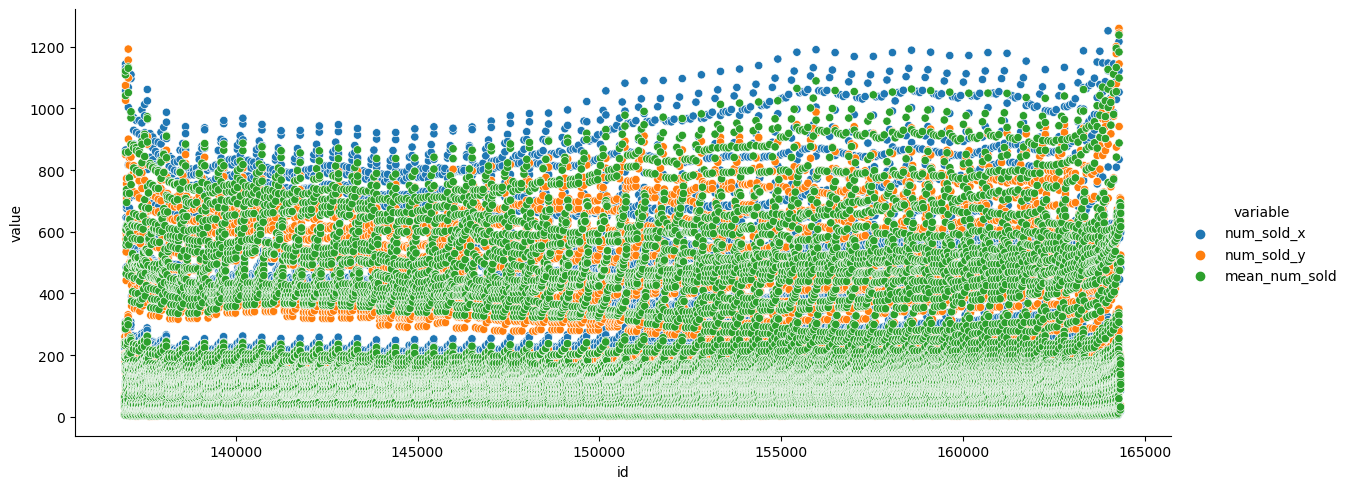

In [162]:
sns.relplot(x='id', y='value', hue='variable', 
             data=pd.melt(outputs, ['id']),kind="scatter", aspect=2.4, height=5)

In [125]:
outputs.shape

(27375, 4)

In [126]:
final_out = pd.DataFrame({'id': outputs.id, 'num_sold': outputs.mean_num_sold})
final_out.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [106]:
#leader score 47.64226